<font size="6"> Overview </font>

This notebook aims to complete the "Contradictory, My Dear Watson" Kaggle competition. The goal is to correctly classify 3 types of sentence pairs using Natural Language Inference (NLI). To accomplish this, I will be fine-tuning a BERT model for this process. This work is generally based on the notebook found here: https://www.kaggle.com/code/anasofiauzsoy/tutorial-notebook. For more information on the competition, see: https://www.kaggle.com/competitions/contradictory-my-dear-watson

In [2]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploration

In [3]:
train = pd.read_csv("train.csv")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


The dataset contains 12,120 sentence pairs as well as the language they are in and the corresponding label, with no null values.

In [92]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [11]:
train['language'].unique()

array(['English', 'French', 'Thai', 'Turkish', 'Urdu', 'Russian',
       'Bulgarian', 'German', 'Arabic', 'Chinese', 'Hindi', 'Swahili',
       'Vietnamese', 'Spanish', 'Greek'], dtype=object)

The data consists of pairs of sentences across 15 languages which fall into 3 categories based on the relationship between the two sentences. Each pair of sentences has a premise and a hypothesis, and they are labeled based on whether the premise entails the hypothesis, contradicts the hypothesis, or is neutral/inconclusive towards the hypothesis. 

The labels are encoded as follows:
entailment: 0
neutral: 1
contradiction: 2

In [10]:
print("premise: " + train['premise'][0])
print("hypothesis: " + train['hypothesis'][0])
print("label: " + str(train['label'][0]))

premise: and these comments were considered in formulating the interim rules.
hypothesis: The rules developed in the interim were put together with these comments in mind.
label: 0


The first row in the training dataset is an example of entailment, since the hypothesis can be inferred directly from the premise.

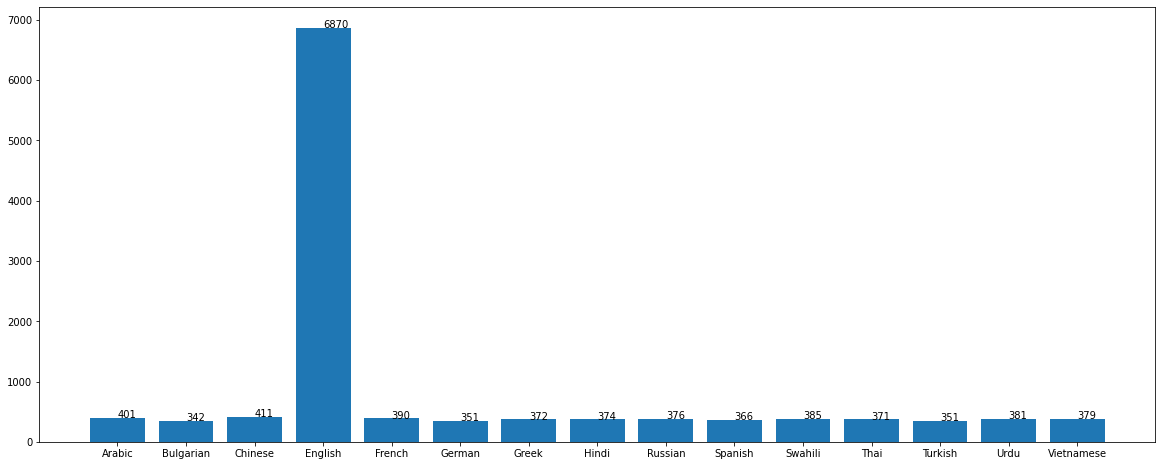

In [32]:
#Visualize distribution of languages
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (20,8))
plt.bar(labels, frequencies)
for x, y, s in zip(labels, frequencies, frequencies):
   plt.text(x, y, s)
plt.show()



The majority of instances are in English, with a relatively even distribution across the other 14 languages present.

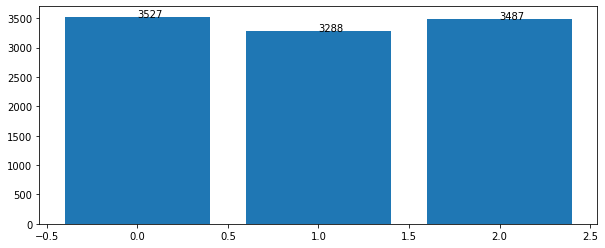

In [25]:
#Visualize distribution of labels
labels, frequencies = np.unique(train.label.values, return_counts = True)

plt.figure(figsize = (10,4))
plt.bar(labels, frequencies)
for x, y, s in zip(labels, frequencies, frequencies):
   plt.text(x, y, s)
plt.show()

We see a relatively even distribution of labels, which is always nice for classification tasks.

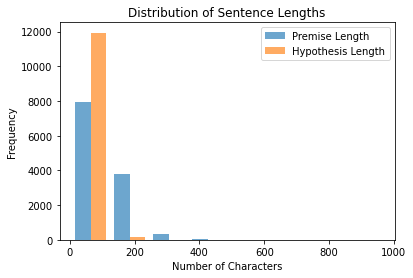

Max length of premisis: 967
Max length of hypothesis: 276


In [93]:
#Visualize sentece lengths

#Calculate lengths of sentences
df=train
df['prem_len'] = df['premise'].apply(len)
df['hyp_len'] = df['hypothesis'].apply(len)

plt.hist([df['prem_len'], df['hyp_len']], bins=8, alpha=0.65, label=['Premise Length', 'Hypothesis Length'])
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()

print("Max length of premisis: " + str(df['prem_len'].max()))
print("Max length of hypothesis: " + str(df['hyp_len'].max()))


Most sentences are under ~150 characters, with a few outliers. Later on we will want to pad these sentences to a specific length for efficiency, so this visualization will help inform that decision. 

In [4]:
#Split data into training and validation sets
train, val = np.split(train.sample(frac = 1), [int(0.85 * len(train))])
print("Number of observations in training data set: {}".format(len(train)))
print("Number of observations in validation data set: {}".format(len(val)))


Number of observations in training data set: 10302
Number of observations in validation data set: 1818


Data Preparation

Use pretrained multilingual BERT model from huggingface - more information can be found at: 
https://github.com/google-research/bert/blob/master/multilingual.md

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [6]:
#Append seperator token to inputs and encode
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [97]:
#Example of an encoded sentence
encode_sentence(train['hypothesis'][0])

[10117,
 23123,
 14628,
 10106,
 10105,
 63313,
 10309,
 14499,
 14229,
 10169,
 11762,
 61565,
 10106,
 21133,
 119,
 102]

In [7]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)


#Create tensors of encoded sentences  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])
  
#Concatenate tokens of sentence pairs preceeded by CLS token
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

#Create input mask of 1s
  input_mask = tf.ones_like(input_word_ids).to_tensor()

#Create type ids for segments - 0 for hypothesis, 1 for premise
  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

#Create input dict
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

This function creates an input for the BERT model in the form of a dictionary consisting of tensors containing the sentence pair, an input mask, and input type ids. The following is a step-by-step example of what this is doing, based on the first 5 words of the previously used example sentences

In [13]:
example_hypothesis = "The rules developed in the interim"
example_premise = "and these comments were considered" 
print("Original Hypothesis:", example_hypothesis)
print("Original Premise:", example_premise)

tokens_hypothesis = [tokenizer.tokenize(s) for s in [example_hypothesis]][0]
tokens_premise = [tokenizer.tokenize(s) for s in [example_premise]][0]
print("\nStep 1: Tokenization")
print("Tokenized Hypothesis:", tokens_hypothesis)
print("Tokenized Premise:", tokens_premise)

sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array([example_hypothesis])])
sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array([example_premise])])
print("\nStep 2: Ragged Tensors")
print("Ragged Tensor for Hypothesis:", sentence1)
print("Ragged Tensor for Premise:", sentence2)

cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
print("\nStep 3: Concatenation of Tokens")
print("Input Word IDs:", input_word_ids)

input_mask = tf.ones_like(input_word_ids).to_tensor()
print("\nStep 4: Input Mask")
print("Input Mask:", input_mask)

type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
print("\nStep 5: Type IDs for Segments")
print("Input Type IDs:", input_type_ids)

inputs = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask,
    'input_type_ids': input_type_ids
}
print("\nStep 6: Constructing the Input Dictionary")
print("Inputs Dictionary:", inputs)

Original Hypothesis: The rules developed in the interim
Original Premise: and these comments were considered

Step 1: Tokenization
Tokenized Hypothesis: ['The', 'rules', 'developed', 'in', 'the', 'interim']
Tokenized Premise: ['and', 'these', 'comments', 'were', 'considered']

Step 2: Ragged Tensors
Ragged Tensor for Hypothesis: <tf.RaggedTensor [[10117, 23123, 14628, 10106, 10105, 63313, 102]]>
Ragged Tensor for Premise: <tf.RaggedTensor [[10111, 11762, 61565, 10309, 14289, 102]]>

Step 3: Concatenation of Tokens
Input Word IDs: <tf.RaggedTensor [[101, 10117, 23123, 14628, 10106, 10105, 63313, 102, 10111, 11762, 61565,
  10309, 14289, 102]]>

Step 4: Input Mask
Input Mask: tf.Tensor([[1 1 1 1 1 1 1 1 1 1 1 1 1 1]], shape=(1, 14), dtype=int32)

Step 5: Type IDs for Segments
Input Type IDs: tf.Tensor([[0 0 0 0 0 0 0 0 1 1 1 1 1 1]], shape=(1, 14), dtype=int32)

Step 6: Constructing the Input Dictionary
Inputs Dictionary: {'input_word_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=


In [8]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)
validation_input = bert_encode(val.premise.values, val.hypothesis.values, tokenizer)

Create and Train Model

In [9]:
max_len = 150

In [10]:
def build_model():
    #create input layers
    bert_encoder = TFBertModel.from_pretrained('bert-base-multilingual-cased')
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    #return embeddings of inputs
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]

    #add a hidden dense layer with relu activation
    #feed in feed CLS token of embeddings
    hidden_layer = tf.keras.layers.Dense(256, activation='relu')(embedding[:, 0, :])

    #dense layer with softmax activation for the 3 classification outputs
    output = tf.keras.layers.Dense(3, activation='softmax')(hidden_layer)
    
    #create model and compile for training using Adam
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [11]:
#Build model with GPU and display summary
strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = build_model()
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 150)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 150)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 150)]                0         []                            
 )                                                                                                
                                                                                              

In [12]:
#Iterate through the dictionary and truncate each tensor
truncated_train_input = {}
for key, tensor in train_input.items():
    truncated_tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post', truncating='post')
    truncated_train_input[key] = truncated_tensor


In [13]:
model.fit(truncated_train_input, train.label.values, epochs = 6, verbose = 1, batch_size = 64)

Epoch 1/6
161/161 [==============================] - 3117s 19s/step - loss: 0.9446 - accuracy: 0.5544
Epoch 2/6
161/161 [==============================] - 3089s 19s/step - loss: 0.7436 - accuracy: 0.6837
Epoch 3/6
161/161 [==============================] - 3085s 19s/step - loss: 0.5525 - accuracy: 0.7794
Epoch 4/6
161/161 [==============================] - 3112s 19s/step - loss: 0.3652 - accuracy: 0.8620
Epoch 5/6
161/161 [==============================] - 3044s 19s/step - loss: 0.2532 - accuracy: 0.9101
Epoch 6/6
161/161 [==============================] - 3039s 19s/step - loss: 0.1811 - accuracy: 0.9395


In [14]:
#Truncate validation set
validation_input_padded = {}  
for key, tensor in validation_input.items():
    truncated_tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post', truncating='post')
    validation_input_padded[key] = truncated_tensor

In [15]:
#Evaluate model on validation set
evaluation_result = model.evaluate(
    {'input_word_ids': validation_input_padded['input_word_ids'],
     'input_mask': validation_input_padded['input_mask'],
     'input_type_ids': validation_input_padded['input_type_ids']},
    val.label.values,
    verbose=1
)

print("Validation Loss:", evaluation_result[0])
print("Validation Accuracy:", evaluation_result[1])

57/57 [==============================] - 162s 3s/step - loss: 1.5965 - accuracy: 0.6232
Validation Loss: 1.5964620113372803
Validation Accuracy: 0.6232123374938965


I was able to increase model accuracy a bit by adjusting the max input length, number of epochs, and other hyperparameters. In order to generate a significantly more accurate model though, I will need to explore other BERT models that may be better suited for this task of natural language inference. This is an example of such a model, and I will explore how this fares if I revisit this problem: https://huggingface.co/symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli

Generate Predictions on Test Set

In [17]:
test = pd.read_csv("test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


In [19]:
#Truncate test set
test_input_padded = {}  
for key, tensor in test_input.items():
    truncated_tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post', truncating='post')
    test_input_padded[key] = truncated_tensor

In [20]:
predictions = [np.argmax(i) for i in model.predict(test_input_padded)]


163/163 [==============================] - 469s 3s/step


In [21]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


In [22]:
submission.to_csv("submission.csv", index = False)